<a href="https://colab.research.google.com/github/Splav12341/H-M_kaggle_competiton/blob/main/product_type_no.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Apr 27 17:50:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:59:00.0 Off |                    0 |
| N/A   35C    P0    49W / 312W |     13MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
DATA_PATH = r"./../H&M/images"

NUM_WORKERS = 8
SIZE_H = SIZE_W = 256

EPOCH_NUM = 30
BATCH_SIZE = 250

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [ ]:
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
import pandas as pd
df = pd.read_csv('./../H&M/articles.csv')
df = df.astype({'article_id': 'str'})

# Make Dataset

In [ ]:
class DatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, df, transform):
        super(DatasetImageFolder, self).__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = []
        self.images_filepaths = []
 
        for directory in tqdm(sorted(os.listdir(os.path.join(DATA_PATH)))):
            for fname in os.listdir(os.path.join(DATA_PATH + '/' + directory)):
                for row in df.values:
                    if fname[1:-4] == row[0]:
                        self.images_filepaths.append(row[0])
                        self.class_names.append(row[1])
                        df = df.drop(df[df.article_id == row[0]].index)
                        break
                        
        self.target_dict = dict()
        for idx, label in enumerate(np.unique(self.class_names)):
            self.target_dict[label] = idx

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        
        image_filepath = ('./../H&M/images/' + '0' + str(test_dataset.images_filepaths[idx])[:2] + '/0' + 
                                str(test_dataset.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
     
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
column = 'product_type_no'
test_dataset = DatasetImageFolder(DATA_PATH, df[['article_id', column]], transformer)

100%|██████████| 86/86 [11:50<00:00,  8.26s/it]


## pseudo balance classes

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([  121,    48,   662,  1305,    50,  1273,   449,   172,   572,
        1154,   366,   242,   235,   836,  1343,   390,   563,  1017,
         236,  1013,   575,   140,    26,    77,    73,   346,  1028,
         123,   383,   186,   733,   200,   244,  1573,   113,     3,
          45,    31,     4,   159,    45,    22,    15,     6,    22,
          20,  1546,  9295,  2979,  4152,  7880,   911,   448,  3975,
        3403,    73,   154,  3940,   460,  1108, 10348,  1147,   309,
        1319,    64, 11150,  1875,  3926,  2689,   130,    89,   172,
           7,    19,  2725,    30,    47,    19,     1,   171,   387,
         220,  1120,   850,   192,    66,  1880,     7,   544,   136,
        2210,    96,  2356,    13,     1,     1,     1,     2,     1,
          10,     6,     1,     5,     2,     2,     9,     1,     1,
           2,     1,     1,     7,     6,    56,     3,     3,     7,
          13,    11,    10,     2,     2,    24,     1,     6,     7,
           2,     1,

In [ ]:
unique

array([ -1,  49,  57,  59,  60,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  98, 100, 102,
       144, 155, 156, 161, 196, 230, 231, 245, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 267, 268, 270, 271,
       272, 273, 274, 275, 276, 277, 283, 284, 285, 286, 287, 288, 289,
       291, 293, 295, 296, 297, 298, 299, 300, 302, 303, 304, 305, 306,
       307, 308, 326, 349, 351, 366, 389, 464, 465, 467, 468, 470, 475,
       476, 477, 483, 489, 491, 492, 493, 494, 495, 496, 498, 499, 503,
       504, 508, 509, 510, 511, 512, 514, 515, 521, 523, 525, 529, 532,
       761, 762])

In [ ]:
df[column].value_counts()

272    11169
265    10362
252     9302
255     7904
254     4155
       ...  
525        1
514        1
351        1
349        1
483        1
Name: product_type_no, Length: 132, dtype: int64

## choose balance_number

In [ ]:
d = dict()
balance_number = 1000.

for idx, value in enumerate(counts):
    weight = int(balance_number/value)
    d[unique[idx]] = weight
print(d)

{-1: 8, 49: 20, 57: 1, 59: 0, 60: 20, 66: 0, 67: 2, 68: 5, 69: 1, 70: 0, 71: 2, 72: 4, 73: 4, 74: 1, 75: 0, 76: 2, 77: 1, 78: 0, 79: 4, 80: 0, 81: 1, 82: 7, 83: 38, 84: 12, 85: 13, 86: 2, 87: 0, 88: 8, 89: 2, 90: 5, 91: 1, 92: 5, 93: 4, 94: 0, 95: 8, 96: 333, 98: 22, 100: 32, 102: 250, 144: 6, 155: 22, 156: 45, 161: 66, 196: 166, 230: 45, 231: 50, 245: 0, 252: 0, 253: 0, 254: 0, 255: 0, 256: 1, 257: 2, 258: 0, 259: 0, 260: 13, 261: 6, 262: 0, 263: 2, 264: 0, 265: 0, 267: 0, 268: 3, 270: 0, 271: 15, 272: 0, 273: 0, 274: 0, 275: 0, 276: 7, 277: 11, 283: 5, 284: 142, 285: 52, 286: 0, 287: 33, 288: 21, 289: 52, 291: 1000, 293: 5, 295: 2, 296: 4, 297: 0, 298: 1, 299: 5, 300: 15, 302: 0, 303: 142, 304: 1, 305: 7, 306: 0, 307: 10, 308: 0, 326: 76, 349: 1000, 351: 1000, 366: 1000, 389: 500, 464: 1000, 465: 100, 467: 166, 468: 1000, 470: 200, 475: 500, 476: 500, 477: 111, 483: 1000, 489: 1000, 491: 500, 492: 1000, 493: 1000, 494: 142, 495: 166, 496: 17, 498: 333, 499: 333, 503: 142, 504: 76, 50

## Balanced dataset 

In [ ]:
class BalancedDatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, transform, class_names, images_filepaths, target_dict):
        super().__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = class_names.copy()
        self.images_filepaths = images_filepaths.copy()
                        
        self.target_dict = target_dict.copy()

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        image_filepath = ('./../H&M/images/' + '0' + str(self.images_filepaths[idx])[:2] + '/0' + 
                                str(self.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
balanced_dataset = BalancedDatasetImageFolder(DATA_PATH, transformer, test_dataset.class_names, test_dataset.images_filepaths, test_dataset.target_dict)

In [ ]:
class_names = []
images_filepaths = []
for name, path in tqdm(zip(balanced_dataset.class_names, balanced_dataset.images_filepaths)):
    
    tmp_names = []
    tmp_paths = []
    if d[name]>0:
        tmp_names.append(name)
        tmp_names = tmp_names*d[name]
        tmp_paths.append(path)
        tmp_paths = tmp_paths*d[name]

        class_names.extend(tmp_names)
        images_filepaths.extend(tmp_paths)
        
balanced_dataset.class_names.extend(class_names)
balanced_dataset.images_filepaths.extend(images_filepaths)    

105100it [00:00, 1548599.90it/s]


## checking

In [ ]:
unique, counts = np.unique(balanced_dataset.class_names, return_counts=True)

In [ ]:
counts

array([ 1089,  1008,  1324,  1305,  1050,  1273,  1347,  1032,  1144,
        1154,  1098,  1210,  1175,  1672,  1343,  1170,  1126,  1017,
        1180,  1013,  1150,  1120,  1014,  1001,  1022,  1038,  1028,
        1107,  1149,  1116,  1466,  1200,  1220,  1573,  1017,  1002,
        1035,  1023,  1004,  1113,  1035,  1012,  1005,  1002,  1012,
        1020,  1546,  9295,  2979,  4152,  7880,  1822,  1344,  3975,
        3403,  1022,  1078,  3940,  1380,  1108, 10348,  1147,  1236,
        1319,  1024, 11150,  1875,  3926,  2689,  1040,  1068,  1032,
        1001,  1007,  2725,  1020,  1034,  1007,  1001,  1026,  1161,
        1100,  1120,  1700,  1152,  1056,  1880,  1001,  1088,  1088,
        2210,  1056,  2356,  1001,  1001,  1001,  1001,  1002,  1001,
        1010,  1002,  1001,  1005,  1002,  1002,  1008,  1001,  1001,
        1002,  1001,  1001,  1001,  1002,  1008,  1002,  1002,  1001,
        1001,  1001,  1010,  1002,  1002,  1008,  1001,  1002,  1001,
        1002,  1001,

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([  121,    48,   662,  1305,    50,  1273,   449,   172,   572,
        1154,   366,   242,   235,   836,  1343,   390,   563,  1017,
         236,  1013,   575,   140,    26,    77,    73,   346,  1028,
         123,   383,   186,   733,   200,   244,  1573,   113,     3,
          45,    31,     4,   159,    45,    22,    15,     6,    22,
          20,  1546,  9295,  2979,  4152,  7880,   911,   448,  3975,
        3403,    73,   154,  3940,   460,  1108, 10348,  1147,   309,
        1319,    64, 11150,  1875,  3926,  2689,   130,    89,   172,
           7,    19,  2725,    30,    47,    19,     1,   171,   387,
         220,  1120,   850,   192,    66,  1880,     7,   544,   136,
        2210,    96,  2356,    13,     1,     1,     1,     2,     1,
          10,     6,     1,     5,     2,     2,     9,     1,     1,
           2,     1,     1,     7,     6,    56,     3,     3,     7,
          13,    11,    10,     2,     2,    24,     1,     6,     7,
           2,     1,

# DataLoader

In [ ]:
img, label, images_filepaths = balanced_dataset[0]
print(img.shape)
print(label)

torch.Size([3, 256, 256])
tensor(48)


In [ ]:
NUM_WORKERS=4
train_loader = DataLoader(balanced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

emb_train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
# train_iter = iter(train_loader)
# it = next(train_iter)
# print(len(it))
# print(it[0].shape)
# print(it[1])

## plot samples

In [ ]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch, images_filepaths = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.class_names
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
#         sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        sample_title = 'Label = %s' % class_names[label_batch[i]]
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

In [ ]:
# plot_from_batch_generator(train_loader)

## define num_classes

In [ ]:
NUM_CLASSES = len(np.unique(train_loader.dataset.class_names))

# Download model

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
# Load pre-trained model
# model_resnet18 = torchvision.models.resnet152(pretrained=True)
from collections import OrderedDict
model = EfficientNet.from_pretrained('efficientnet-b4')

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE
for p in model.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model._fc.in_features

# hid_size = 200
emb_size = 20
model._fc = nn.Linear(num_feat, emb_size)

model = nn.Sequential(OrderedDict([
          ('efficientnet', model),
          ('leaky_relu1', nn.LeakyReLU(0.3)),
          ('lin', nn.Linear(emb_size, NUM_CLASSES)),
          ('leaky_relu2', nn.LeakyReLU(0.3))
]))

# Use available device for calculations
model = model.to(device)

Loaded pretrained weights for efficientnet-b4


In [ ]:
!mkdir ./models
CHECKPOINT_PATH = "./models/save1"

mkdir: cannot create directory ‘./models’: File exists


In [ ]:
# torch.save(model.state_dict(),CHECKPOINT_PATH)
# model.load_state_dict(torch.load(CHECKPOINT_PATH))
# model = model.to(device)

In [ ]:
# model(it[0].to(device)).shape

## tensorboard

In [ ]:
!rm -r ./runs/log

rm: cannot remove './runs/log': Directory not empty


In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/log')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs --bind_all --port=6007# bind_all for remoted python
# # or use http://tpls-sgmta00001.sigma.sbrf.ru:6006/

## training

In [ ]:
from IPython.display import clear_output
import time
from sklearn.metrics import accuracy_score

def fit(model, epochs, lr):
    torch.cuda.empty_cache()
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    train_losses = []
    accuracy = []
    start = time.time()
    i=0
    flag = False
    for epoch in range(epochs):
        model.train(True)
        for img, label, images_filepaths in tqdm(train_loader):
            clear_output(True)
            img = img.to(device)
            label = label.to(device)
            opt.zero_grad()
            preds = model(img).to(device)
            ce_loss = nn.CrossEntropyLoss()
            loss = ce_loss(preds, label)
            loss.backward()
            opt.step()
            tmp_loss = loss.item()
            train_losses.append(tmp_loss)
            
            end = time.time() - start
            
            acc = accuracy_score(label.cpu(), np.argmax(preds.cpu().detach().numpy(), axis=1))
            accuracy.append(acc)
            
            # if i%10==1:
            plt.plot(np.arange(0, len(train_losses)), train_losses, label=f'spent_time={end}, ep={epoch}')
            plt.legend()
            plt.show()

            plt.plot(np.arange(0, len(accuracy)), accuracy, label='accuracy')
            plt.legend()
            plt.show()
            
            if (np.mean(accuracy[-5:])>0.75):
                flag = True
            
            # writer.add_scalar('loss', tmp_loss, i)
            # writer.add_scalar('accuracy', acc, i)
            
            i+=1
        
        torch.save(model.state_dict(),CHECKPOINT_PATH)
        if flag == True:
            break
    model.train(False)
    writer.close()
    return model

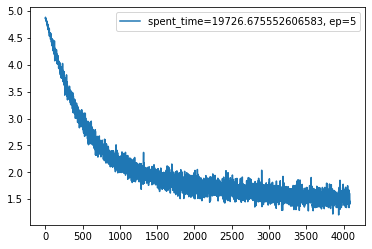

  5%|▌         | 44/808 [03:18<57:21,  4.51s/it]


KeyboardInterrupt: 

In [ ]:
EPOCH_NUM=100
model = fit(model, EPOCH_NUM , lr=0.0003)

In [ ]:
torch.save(model.state_dict(),CHECKPOINT_PATH)

In [ ]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model = model.to(device)

# Make embeddings

In [ ]:
df = np.zeros((len(test_dataset.images_filepaths), emb_size+1))
i=0
for img, label, images_filepaths in tqdm(emb_train_loader):
    img = img.to(device)
    preds = model.efficientnet(img).cpu().detach().numpy()
    
    for k in range(img.shape[0]):
        df[i*BATCH_SIZE + k, 0] = int(images_filepaths[k])
        for m in range(emb_size):
            df[i*BATCH_SIZE + k, m+1] = preds[k,m:m+1][0]
    i+=1
    
df = pd.DataFrame(df)
print(df.shape)
df.head()

 50%|█████     | 211/421 [14:06<09:06,  2.60s/it]

aaaaa: ./../H&M/images/061/0616100001.jpg


100%|██████████| 421/421 [28:32<00:00,  4.07s/it]

(105100, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,731985001.0,2.994194,4.241562,-2.868546,-3.128559,0.719550,3.129874,2.509374,-2.994750,1.544502,...,2.282867,-1.418456,2.482316,0.265031,4.023338,-3.676731,2.789105,3.580810,-2.182226,1.945852
1,768992001.0,1.612334,0.077584,2.205141,13.581420,2.362908,5.214824,5.604954,4.838928,6.989165,...,4.048374,7.022014,7.646264,2.621736,-1.670957,-2.222898,5.880712,7.948969,6.732757,8.424791
2,599074003.0,2.994942,4.308848,-3.210676,3.174331,4.860772,1.771442,4.509799,3.517703,2.079408,...,-2.326030,1.115398,2.047053,-0.070947,6.705506,3.571543,1.371255,2.363821,0.266854,2.573630
3,747474001.0,1.735365,6.563901,-2.666107,0.181467,1.999983,6.046667,7.012327,-0.153060,-0.637658,...,1.040345,5.799710,3.771623,2.089844,5.029505,2.617890,3.022340,0.277686,-1.758441,6.393712
4,665188002.0,6.150174,5.119413,4.873886,1.113933,0.188778,3.057647,1.603413,0.339739,2.886212,...,5.963342,-4.205397,0.591804,2.037338,2.474230,1.740465,7.284883,1.139745,2.296670,1.678148


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,731985001.0,2.994194,4.241562,-2.868546,-3.128559,0.719550,3.129874,2.509374,-2.994750,1.544502,...,2.282867,-1.418456,2.482316,0.265031,4.023338,-3.676731,2.789105,3.580810,-2.182226,1.945852
1,768992001.0,1.612334,0.077584,2.205141,13.581420,2.362908,5.214824,5.604954,4.838928,6.989165,...,4.048374,7.022014,7.646264,2.621736,-1.670957,-2.222898,5.880712,7.948969,6.732757,8.424791
2,599074003.0,2.994942,4.308848,-3.210676,3.174331,4.860772,1.771442,4.509799,3.517703,2.079408,...,-2.326030,1.115398,2.047053,-0.070947,6.705506,3.571543,1.371255,2.363821,0.266854,2.573630
3,747474001.0,1.735365,6.563901,-2.666107,0.181467,1.999983,6.046667,7.012327,-0.153060,-0.637658,...,1.040345,5.799710,3.771623,2.089844,5.029505,2.617890,3.022340,0.277686,-1.758441,6.393712
4,665188002.0,6.150174,5.119413,4.873886,1.113933,0.188778,3.057647,1.603413,0.339739,2.886212,...,5.963342,-4.205397,0.591804,2.037338,2.474230,1.740465,7.284883,1.139745,2.296670,1.678148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105095,756099006.0,2.222937,-0.211029,-1.454410,6.160294,-1.565254,7.794731,4.425190,2.555802,3.886233,...,-1.025774,4.051438,8.301147,0.867091,2.382906,1.257830,2.378281,2.663671,5.419829,2.042294
105096,902874001.0,2.007353,5.746308,2.142246,7.100118,-0.788274,1.256388,-0.953932,5.817311,5.905631,...,5.867220,-1.176309,3.913308,-0.250143,-3.981148,2.055040,1.295731,3.077320,3.382244,1.651125
105097,512972002.0,4.641219,3.706736,3.595165,-1.968270,6.209640,8.210551,-2.062597,-3.272281,5.053578,...,8.498046,0.697883,-2.938936,2.723743,4.350425,-1.741276,5.440692,5.570922,3.524458,2.812809
105098,763858002.0,3.688154,1.721997,1.887282,3.182931,2.773946,5.029028,4.839123,0.314462,8.273583,...,1.830853,5.323287,1.868093,1.938050,2.436076,2.210815,9.429467,4.631519,1.556428,5.065269


In [ ]:
df.to_csv('./checkpoint1.csv')